# Using Intake-ESM to Analyze Data from CESM2-LE

In mid June, the [CESM2 Large Ensemble](https://www.cesm.ucar.edu/projects/community-projects/LENS2/) dataset was made available to the public. This model was run in collaboration with the [IBS Center for Climate Physics](https://ibsclimate.org/) and the [National Center for Atmospheric Research](https://ncar.ucar.edu/) This dataset includes 100 ensemble members, at one degree spatial resolution, with each ensemble member including data from 1850 to 2100. If you are interested in learning more about how this ensemble was setup, be sure to check out [the main webpage](https://www.cesm.ucar.edu/projects/community-projects/LENS2/) or read the pre-print of [Rodgers et al. 2021](https://esd.copernicus.org/preprints/esd-2021-50/) which describes this dataset in detail.

## Main Challenge

One of these challenges with this dataset is dealing with the massive amount of output. The data are available through the [NCAR Climate Data Gateway](https://www.cesm.ucar.edu/projects/community-projects/LENS2/data-sets.html) and via the [IBS OpenDAP Server](https://climatedata.ibs.re.kr/data/cesm2-lens). There is also a subset of the dataset available on the GLADE file system on NCAR HPC resources available within the directory `/glade/campaign/cgd/cesm/CESM2-LE/timeseries/`. 

Through these traditional file-access methods, one would need to scroll through and find one or a few of the **millions** of files produced by the model. Fortunately, this dataset has been catalogued, available using the [`Intake-esm`](https://intake-esm.readthedocs.io/en/latest/) package, which enables one to query the data, and read into a dictionary of `xarray.Datasets`, preventing the user from having to setup the concatenation and file search themselves.

Within the [intake-esm FAQ](https://intake-esm.readthedocs.io/en/latest/supplemental-guide/faq.html) section, there is a list of existing catalogs, as shown below:

![intake-esm catalogs](../images/intake_esm_catalogs.png)

At the top of the ["Is there a list of existing catalogs"](https://intake-esm.readthedocs.io/en/latest/supplemental-guide/faq.html) section, you can see the `CMIP6-GLADE` catalog, which includes:
* Description of the catalog
* Platform
* Catalog path or url
* Data format
* Documentation page

---

For the CESM2-LE Catalog, we see:

**CESM2-LE-GLADE**

* Description: ESM collection for the CESM2 LENS data stored on GLADE in /glade/campaign/cgd/cesm/CESM2-LE/timeseries
* Platform: NCAR-GLADE
* Catalog path or url: /glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json
* Data Format: netCDF
* Documentation Page: https://www.cesm.ucar.edu/projects/community-projects/LENS2/

We are **most interested** in the catalog path here

## Using the Catalog

Now that we found the catalog file, and see that it is the dataset we are interested in, we can start our analysis!

### Imports

In [5]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
from distributed import Client
from ncar_jobqueue import NCARCluster

### Spin up our Dask Cluster

In [2]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster()

# Spin up 20 workers
cluster.scale(20)

# Assign the cluster to our Client
client = Client(cluster)

In [3]:
client

<Client: 'tcp://10.12.206.59:39383' processes=0 threads=0, memory=0 B>

### Read in the data catalog

As mentioned before, we use the catalog path `/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json`

In [4]:
cat = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mgrover/miniconda3/envs/hires-marbl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Let's take a second to investigate the catalog - each file on disk represents an `asset`, which means that there are over 4 **million** files within the `/glade/campaign/cgd/cesm/CESM2-LE/timeseries/` directory

In [6]:
cat

,unique
component,6
stream,25
case,36
member_id,90
experiment,2
forcing_variant,2
control_branch_year,14
variable,1868
start_time,184
end_time,185


### Querying for our desired variable
In this case, we are interested in the surface temperature in Boulder, Colorado. There are **numerous** temperature variables in the dataset, we can search for all the `long_names` from atmospheric output.

We can use the wildcard here `*` to look for where both captial and lowercase `temperature` show up in the `long_name`

In [12]:
cat.search(component='atm', long_name=['temperature*', 'Temperature*']).df.long_name.unique()

array(['sea surface temperature',
       'Minimum reference height temperature over output period',
       'Tropopause Temperature', 'Reference height temperature',
       'Total temperature tendency',
       'Minimum surface temperature over output period',
       'Temperature tendency',
       'Maximum reference height temperature over output period',
       'Temperature', 'Maximum surface temperature over output period',
       'Potential Temperature', 'Temperature Variance',
       'Surface temperature (radiative)',
       'Temperature at  700 mbar pressure surface',
       'Temperature at 700 mbar pressure surface',
       'Temperature at 200 mbar pressure surface',
       'Temperature at  200 mbar pressure surface',
       'Temperature at 1000 mbar pressure surface',
       'Temperature at  100 mbar pressure surface',
       'Temperature at   50 mbar pressure surface',
       'Temperature at 500 mbar pressure surface',
       'Temperature at  500 mbar pressure surface',
       'L

### Query and Subset our Catalog
Let's go with `Lowest model level temperature` since this represents the closest to the surface without being at the **actual** surface of the earth. We pass the `component` and `long_name` into the query, which reduces the number of datasets to 8!

In [13]:
subset = cat.search(component='atm', long_name='Lowest model level temperature')

In [14]:
subset

,unique
component,1
stream,1
case,8
member_id,40
experiment,2
forcing_variant,1
control_branch_year,4
variable,1
start_time,26
end_time,26


## Read in using `.to_dataset_dict()`

We include the additional `dask.config.set()` to help with splitting up large chunks when reading in

In [15]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.control_branch_year.variable'


In [28]:
dsets.keys()

dict_keys(['atm.historical.cam.h1.smbb.1231.TBOT', 'atm.historical.cam.h1.smbb.1251.TBOT', 'atm.ssp370.cam.h1.smbb.1281.TBOT', 'atm.historical.cam.h1.smbb.1301.TBOT', 'atm.ssp370.cam.h1.smbb.1251.TBOT', 'atm.ssp370.cam.h1.smbb.1301.TBOT', 'atm.historical.cam.h1.smbb.1281.TBOT', 'atm.ssp370.cam.h1.smbb.1231.TBOT'])

Let's take a look at the keys - these are defined by the `groupby` attributes in the catalog. The groupby attributes in this case are:

`component.experiment.stream.forcing_variant.control_branch_year.variable`
* Component - which component this output is from (ex. atm represents the atmosphere)
* Experiment - which experiment this is from, in this case, this is `ssp370` which is one of the CMIP6 future experiments
* Stream - which stream this output is from, in this case, this is `cam.h1`, which represents daily output
* Control Branch Year - which year the ensemble branched off from, these are described within the [CESM2-LE documentation page](https://www.cesm.ucar.edu/projects/community-projects/LENS2/)
* Variable - which variable you are working with


### Define a helper function which subsets the data, groups by year, and returns the data array

In [29]:
def subset_ds(ds):
    # Subset for TBOT and choose Boulder, Colorado's lat and lon and convert to degC
    da = ds.TBOT.sel(lat=40.015, lon=-105.2705, method='nearest') - 273.15
    da = da.groupby('time.year').mean()

    # Make sure that time is the format of a string
    da['year'] = da.year.astype(int)

    return da

#### Look at one of the datasets

In [30]:
ds = dsets['atm.ssp370.cam.h1.smbb.1301.TBOT']

#### Apply our function

In [32]:
da = subset_ds(ds)

### Plot our Results!

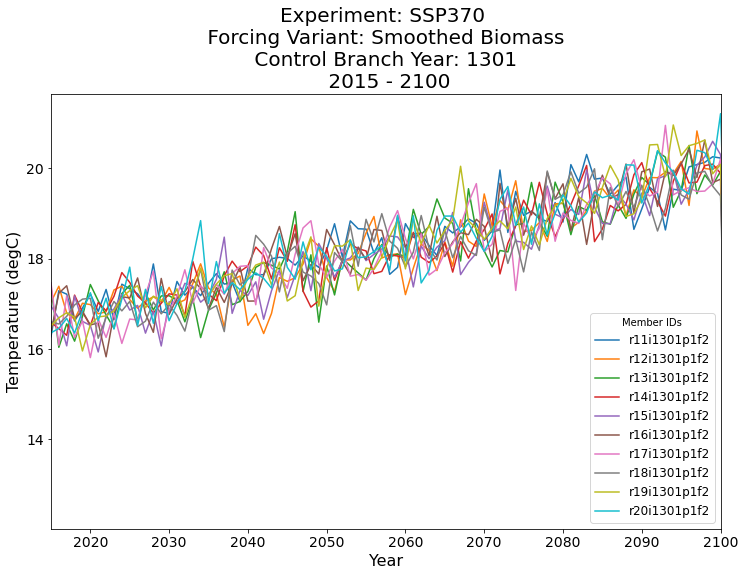

In [51]:
# Setup the figure
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Loop through and plot each member_id
for member_id in da.member_id.values:
    da.sel(member_id=member_id).plot(ax=ax, label=member_id)

# Limit the axis from 2015 to 2100
plt.xlim(2015, 2100)

# Increase the ticksize
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add some labels and increase the size
plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature (degC)', fontsize=16)

# Add a legend
plt.legend(title='Member IDs', fontsize=12)

# Add a title
plt.title(
    'Experiment: SSP370 \n Forcing Variant: Smoothed Biomass \n Control Branch Year: 1301 \n 2015 - 2100',
    fontsize=20,
);

## Conclusion
While this was a generally simple analysis, I hope this helps you see how powerful `intake-esm` can be when working with large datasets such as the CESM2-Large Ensemble!